# GCN

## Karim Saraipour and Dezhou Chen


### Importing torch and geometric libraries and packages

In [173]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
import networkx as nx


## Reference Paper For GCN : [Paper](https://arxiv.org/pdf/1609.02907.pdf)

## Loading Data

In [174]:
##download datasets
##define device
dataset_cora = Planetoid(root="./data/Cora", name='Cora')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset_cora[0].to(device)

In [175]:
##lets's dig into the properties of cora
print(type(dataset_cora))
print(type(dataset_cora[0]))
print(type(dataset_cora.data))
print(dataset_cora[0])
print(dataset_cora.data)
print(dataset_cora.data.keys)

<class 'torch_geometric.datasets.planetoid.Planetoid'>
<class 'torch_geometric.data.data.Data'>
<class 'torch_geometric.data.data.Data'>
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
['y', 'test_mask', 'val_mask', 'edge_index', 'train_mask', 'x']


In [176]:
##check nodes within each of the classes/classifications in cora dataset
##number of classes within cora
##number of node features within cora, each of node features is 1433
node_classes = dataset_cora.data.y.data.numpy()
print(node_classes)
print(dataset_cora.num_classes)
print(dataset_cora.num_node_features)

[3 4 4 ... 3 3 3]
7
1433


### Training function

In [177]:
##define training function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss.item()

### Testing function

In [178]:
##define testing function

@torch.no_grad()
def test(model, data):
    model.eval()

    _, pred = model(data).max(dim = 1)

    correct_train = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
    acc_train = correct_train / data.train_mask.sum().item()

    correct_val = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
    acc_val = correct_val / data.val_mask.sum().item()

    correct_test = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc_test = correct_test / data.test_mask.sum().item()

    return acc_train, acc_val, acc_test

In [179]:
##define an interactive data viz function
##but only regard as a way to examine if the model is overfitting
from livelossplot import PlotLosses

def live_plot(model, epoch_num=100):
    liveloss = PlotLosses()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for epoch in range(epoch_num):
        loss = train(model, dataset_cora[0], optimizer)
        acc_train, acc_val, acc_test = test(model, dataset_cora[0])

        logs = {
            'loss': loss,
            'acc_val': acc_val,
            'acc_test': acc_test,
        }
        liveloss.update(logs)
        liveloss.send()

In [180]:
## define a function to convert data into adjacent matrix
from torch_geometric.utils import to_dense_adj

def convert_data_to_adj(data):
    feature, edge_index = data.x, data.edge_index
    adj = torch.squeeze(to_dense_adj(edge_index))
    return feature, adj

### Model Defimitions (Paper, PyG Documentation)

In [181]:
# graph convolution model from paper

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class GraphConvolution(Module):
    
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
            
    def forward(self, data):
        input, adj = convert_data_to_adj(data)
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output
        
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


## graph convolution model from PyG
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    

### Model Statistics and Visualizations

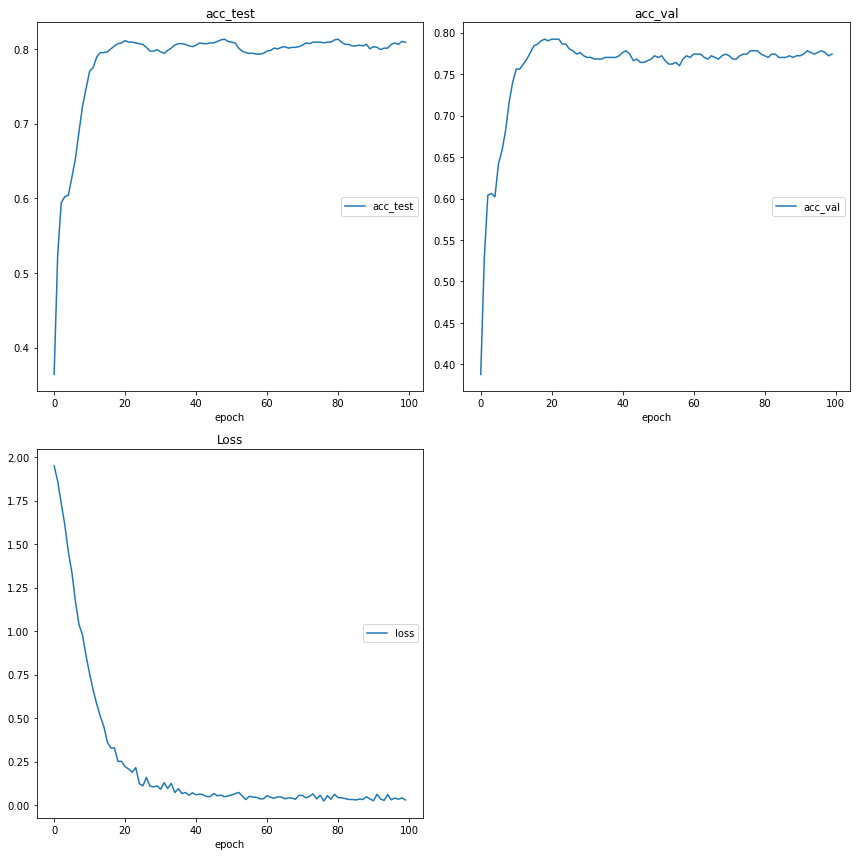

acc_test
	acc_test         	 (min:    0.364, max:    0.813, cur:    0.809)
acc_val
	acc_val          	 (min:    0.388, max:    0.792, cur:    0.774)
Loss
	loss             	 (min:    0.023, max:    1.950, cur:    0.029)


In [182]:
gcn_model = GCN(dataset_cora.num_features, dataset_cora.num_classes)
live_plot(gcn_model, epoch_num = 100)

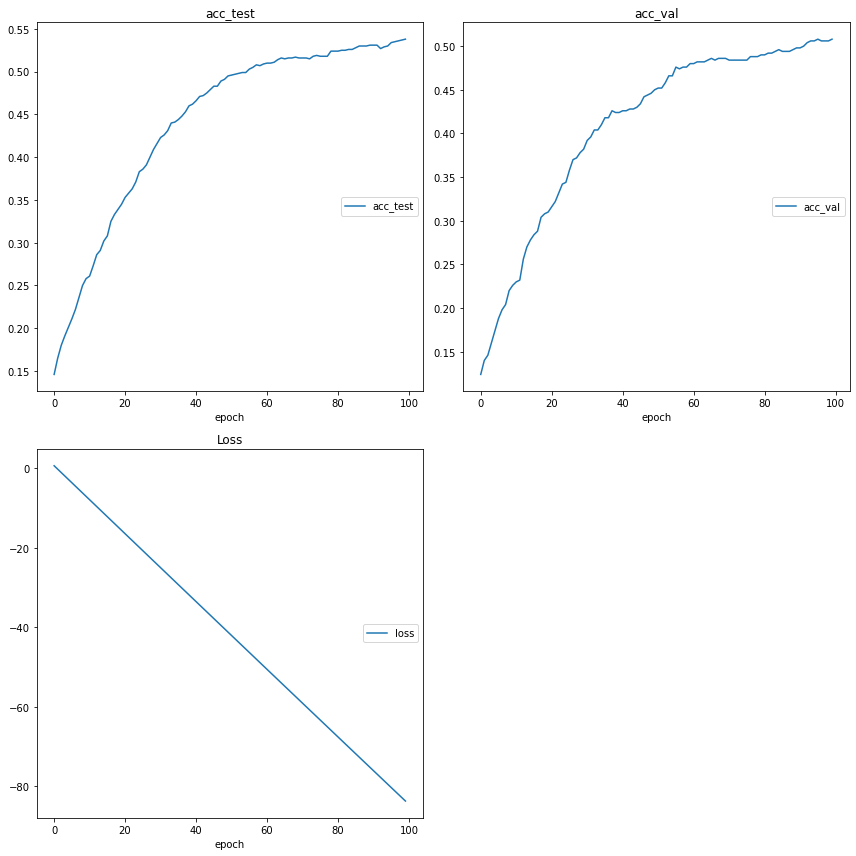

acc_test
	acc_test         	 (min:    0.146, max:    0.538, cur:    0.538)
acc_val
	acc_val          	 (min:    0.124, max:    0.508, cur:    0.508)
Loss
	loss             	 (min:  -83.659, max:    0.659, cur:  -83.659)


In [183]:
gcn_model = GraphConvolution(dataset_cora.num_features, dataset_cora.num_classes)
live_plot(gcn_model, epoch_num = 100)